In [1]:
!python -V

Python 3.10.11


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# Data loading


The data comes from the NYC taxi system, sourced from https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

We are trying to predict duration of a taxi ride (in minutes) from this data.

In [3]:
df_01 = pd.read_parquet('./../data/green_tripdata_2022-01.parquet')

df_01.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2022-01-01 00:14:21,2022-01-01 00:15:33,N,1.0,42,42,1.0,0.44,3.5,0.50,0.5,0.00,0.0,None,0.3,4.80,2.0,1.0,0.00
1,1,2022-01-01 00:20:55,2022-01-01 00:29:38,N,1.0,116,41,1.0,2.10,9.5,0.50,0.5,0.00,0.0,None,0.3,10.80,2.0,1.0,0.00
2,1,2022-01-01 00:57:02,2022-01-01 01:13:14,N,1.0,41,140,1.0,3.70,14.5,3.25,0.5,4.60,0.0,None,0.3,23.15,1.0,1.0,2.75
3,2,2022-01-01 00:07:42,2022-01-01 00:15:57,N,1.0,181,181,1.0,1.69,8.0,0.50,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2022-01-01 00:07:50,2022-01-01 00:28:52,N,1.0,33,170,1.0,6.26,22.0,0.50,0.5,5.21,0.0,None,0.3,31.26,1.0,1.0,2.75


# EDA and Data Transformation

In [4]:
df_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62495 entries, 0 to 62494
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               62495 non-null  int64         
 1   lpep_pickup_datetime   62495 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  62495 non-null  datetime64[ns]
 3   store_and_fwd_flag     56200 non-null  object        
 4   RatecodeID             56200 non-null  float64       
 5   PULocationID           62495 non-null  int64         
 6   DOLocationID           62495 non-null  int64         
 7   passenger_count        56200 non-null  float64       
 8   trip_distance          62495 non-null  float64       
 9   fare_amount            62495 non-null  float64       
 10  extra                  62495 non-null  float64       
 11  mta_tax                62495 non-null  float64       
 12  tip_amount             62495 non-null  float64       
 13  t

In [5]:
df_01['PULocationID'].nunique(), df_01['DOLocationID'].nunique()

(231, 240)

While a combination of pickup location ID and dropoff location ID might have been useful in predicting trip duration, there are too many possible combinations here that we would probably need a lot more data to train using these variables.

<Axes: xlabel='trip_distance', ylabel='fare_amount'>

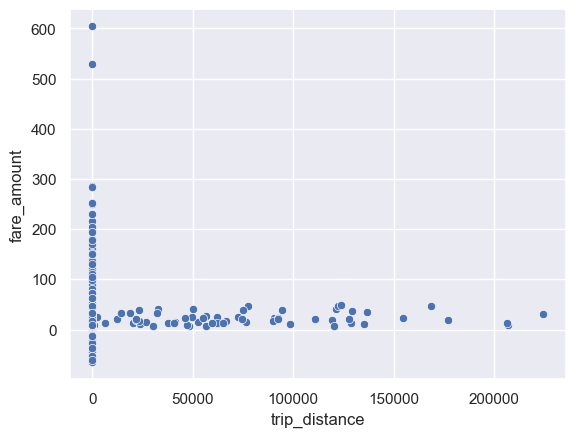

In [6]:
sns.scatterplot(data=df_01, x="trip_distance", y="fare_amount")

We probably should filter on `trip_distance` so as to avoid training on outliers.

Some columns, such as VendorID, should ideally be categorical, but are listed as int64.
Fixing that...

In [7]:
# As per the data dictionary made available at 
# https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf
# this seems like a reasonable mapping

convert_dtypes = {
    'VendorID': 'category',
    'PULocationID': 'string',
    'DOLocationID': 'string',
    'RatecodeID': 'category',
    'passenger_count': 'Int64',
    'store_and_fwd_flag': 'category',
    'trip_type': 'category',
    'payment_type': 'category'
}

(df_01.astype(convert_dtypes)
     .describe(percentiles=[.01, .05, .95, .99])
     #.mode(axis=0)
)

,lpep_pickup_datetime,lpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
count,62495,62495,56200.0,62495.000000,62495.000000,62495.00000,62495.000000,62495.000000,62495.000000,62495.000000,62495.000000,56200.000000
mean,2022-01-16 14:18:36.026353920,2022-01-16 14:37:37.189551104,1.258399,77.758632,13.914000,0.34756,0.426322,1.666540,0.208182,0.297312,17.490532,0.706628
min,2009-01-01 00:34:01,2009-01-01 17:05:20,0.0,0.000000,-65.000000,-4.50000,-0.500000,-0.860000,-6.550000,-0.300000,-71.850000,0.000000
1%,2022-01-01 13:43:59.460000,2022-01-01 14:02:46.220000,1.0,0.000000,2.500000,0.00000,0.000000,0.000000,0.000000,0.300000,3.300000,0.000000
5%,2022-01-03 08:45:52.800000,2022-01-03 09:02:09.100000,1.0,0.000000,4.500000,0.00000,0.000000,0.000000,0.000000,0.300000,5.800000,0.000000
50%,2022-01-16 15:59:42,2022-01-16 16:17:00,1.0,1.900000,10.500000,0.00000,0.500000,1.000000,0.000000,0.300000,13.860000,0.000000
95%,2022-01-30 14:16:16.200000,2022-01-30 14:32:46,3.0,8.463000,35.000000,1.00000,0.500000,5.710000,0.000000,0.300000,41.350000,2.750000
99%,2022-01-31 17:31:33.680000,2022-01-31 17:50:49.660000,6.0,15.561200,57.500000,3.25000,0.500000,10.000000,6.550000,0.300000,67.010600,2.750000
max,2022-01-31 23:57:37,2022-02-01 21:01:54,8.0,224481.380000,604.500000,4.50000,0.500000,76.770000,44.750000,0.300000,605.300000,2.750000
std,NaN,NaN,0.877743,2909.354163,12.088819,0.65781,0.181381,2.484928,1.257659,0.037201,13.623416,1.201632


Based on the information above, it seems like it would be a good idea to filter out outlier/erroneous records based on the `total_amount` and `trip_distance` columns.

For the sake of this exercise, let us also filter on most other columns, and just use a couple of select columns as features.

In [8]:
# Using modes of most columns to filter the data

(df_01.astype(convert_dtypes)
     .store_and_fwd_flag.value_counts()
)

store_and_fwd_flag
N    55591
Y      609
Name: count, dtype: int64

In [9]:
len_vect = np.vectorize(len)

PU_len = len_vect(df_01['PULocationID'].astype(str)).max()
DO_len = len_vect(df_01['DOLocationID'].astype(str)).max()

PU_len, DO_len

(3, 3)

In [10]:
(
    df_01.astype(convert_dtypes)
    .assign(
        trip_duration=(df_01['lpep_dropoff_datetime'] - df_01['lpep_pickup_datetime']).dt.total_seconds() / 60,
    )
    #.describe(percentiles=[.01, .05, .95, .99])
    #.boxplot(column='trip_duration', by='payment_type', grid=False)
    #.query("trip_duration == 86309") # outlier
    .query("total_amount >= 3.300000 and trip_distance <= 15.561200") # removing outliers
    .query("trip_duration >= 2.350000 and trip_duration <= 68.453000") # removing outliers
    .query("trip_type == 1 and RatecodeID == 1 and VendorID == 2") # keeping the data simple
    .reset_index()
    .drop(['ehail_fee'], axis=1) # the column has only NULL values
    .drop(['index', 'trip_type', 'RatecodeID', 'VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime', 'PULocationID', 
           'store_and_fwd_flag', 'passenger_count', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'DOLocationID', 
           'tolls_amount', 'improvement_surcharge', 'payment_type', 'congestion_surcharge'], axis=1)
    .info()
    #.query("PULocationID != DOLocationID")
    #.head()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42001 entries, 0 to 42000
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   trip_distance  42001 non-null  float64
 1   total_amount   42001 non-null  float64
 2   trip_duration  42001 non-null  float64
dtypes: float64(3)
memory usage: 984.5 KB


We'll put the above in a transform function, so that data can be easily transformed after loading, in case we want to use data from other files (each file is for a particular month) in the future.

In [11]:
def transform_nyc_green(df):
    
    convert_dtypes = {
        'VendorID': 'category',
        'PULocationID': 'string',
        'DOLocationID': 'string',
        'RatecodeID': 'category',
        'passenger_count': 'Int64',
        'store_and_fwd_flag': 'category',
        'trip_type': 'category',
        'payment_type': 'category'
    }

    return (
        df.astype(convert_dtypes)
        .assign(
            trip_duration=(df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']).dt.total_seconds() / 60,
        )
        .query("total_amount >= 3.300000 and trip_distance <= 15.561200") # removing outliers
        .query("trip_duration >= 2.350000 and trip_duration <= 68.453000") # removing outliers
        .query("trip_type == 1 and RatecodeID == 1 and VendorID == 2") # keeping the data simple
        .reset_index()
        .drop(['ehail_fee'], axis=1) # the column has only NULL values
        .drop(['index', 'trip_type', 'RatecodeID', 'VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime', 'PULocationID', 
               'store_and_fwd_flag', 'passenger_count', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'DOLocationID', 
               'tolls_amount', 'improvement_surcharge', 'payment_type', 'congestion_surcharge'], axis=1)
    )



For example, loading and transforming Feb data...


In [12]:
df_02 = pd.read_parquet('./../data/green_tripdata_2022-02.parquet')
display(df_02.head())

print("\n")
df_02 = transform_nyc_green(df_02)
df_02.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2022-02-01 00:20:21,2022-02-01 00:24:30,N,1.0,43,238,1.0,1.16,5.5,0.5,0.5,1.02,0.0,None,0.3,7.82,1.0,1.0,0.00
1,2,2022-02-01 00:32:26,2022-02-01 00:35:31,N,1.0,166,24,1.0,0.57,4.5,0.5,0.5,0.00,0.0,None,0.3,5.80,2.0,1.0,0.00
2,1,2022-02-01 00:17:27,2022-02-01 00:44:44,N,1.0,226,219,1.0,0.00,42.2,0.0,0.5,0.00,0.0,None,0.3,43.00,1.0,1.0,0.00
3,2,2022-02-01 00:45:37,2022-02-01 01:27:16,N,1.0,89,83,1.0,16.62,49.0,0.5,0.5,0.00,0.0,None,0.3,50.30,2.0,1.0,0.00
4,2,2022-02-01 00:06:46,2022-02-01 00:30:06,N,1.0,7,238,1.0,5.97,21.0,0.5,0.5,4.50,0.0,None,0.3,29.55,1.0,1.0,2.75


,trip_distance,total_amount,trip_duration
0,1.16,7.82,4.150000
1,0.57,5.80,3.083333
2,5.97,29.55,23.333333
3,1.77,11.76,8.783333
4,0.50,5.30,2.650000


Back to Jan data, and visualising the data we have now...

In [13]:
df_01 = transform_nyc_green(df_01)
df_01.head()

,trip_distance,total_amount,trip_duration
0,1.69,9.30,8.250000
1,6.26,31.26,21.033333
2,6.47,23.80,20.200000
3,1.15,7.30,6.333333
4,1.30,7.30,6.000000


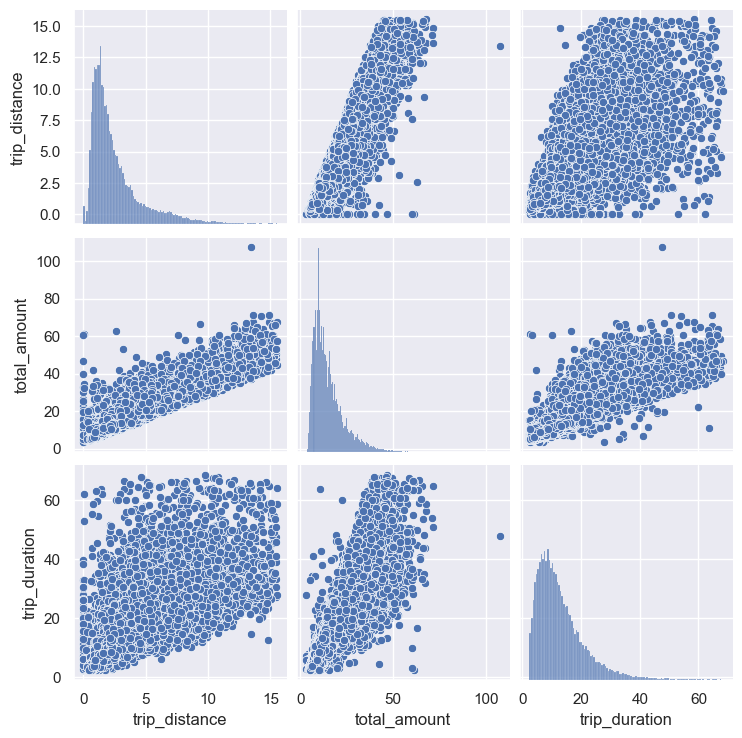

In [14]:
sns.pairplot(df_01)

Let's try to model the data now.

# Modeling

Let's fit a basic model with just the 2 numerical columns, first.

In [15]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

In [16]:
features = ['trip_distance', 'total_amount']
target = ['trip_duration']


## OLS Linear Regression

In [17]:
X = df_01[features]
y = df_01[target]


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                   random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

RMSE = mean_squared_error(y_test, y_pred, squared=False)

RMSE

4.522799576241804

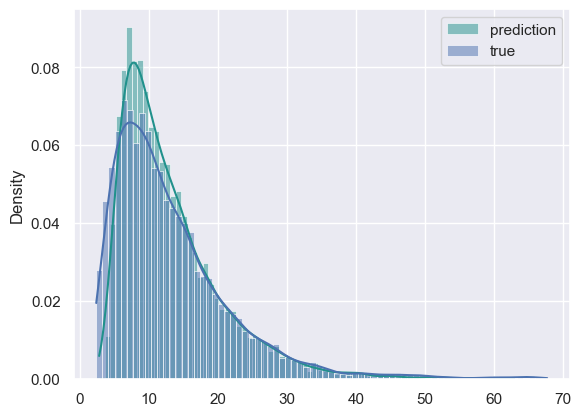

In [19]:
sns.histplot(y_pred, label='prediction', kde=True, stat="density", palette='viridis')
sns.histplot(y_test, label='true', kde=True, stat="density")

plt.legend()

Looks like we're able to capture some information using this simlpe model. 

Trying another linear model (Lasso) to see if there is any improvement...

## Lasso

In [20]:
lasso = Lasso()
lasso.fit(X_train, y_train)

y_pred = lasso.predict(X_test)

RMSE = mean_squared_error(y_test, y_pred, squared=False)

RMSE

4.577989971494258

In [21]:
lasso.coef_

array([-0.        ,  0.84270536])

In [22]:
X_train.iloc[:3, lasso.coef_ != 0]

,total_amount
15137,35.85
5777,7.30
14156,55.26


The coefficients seem to suggest that the `trip_distance` column is not contributing much here and can be removed; and yet the RMSE is almost as good as it was in the case of the simple LR model. This is probably a trade-off worth considering to make here if one of these models is going to be in production.

## Scaling the variables

Although the variables are not very different in scale, let's try scaling to see if it helps at all.

In [23]:
scaler = StandardScaler()

X_tr_scaled = scaler.fit_transform(X_train)
X_te_scaled = scaler.transform(X_test)

lr_ = LinearRegression()
lr_.fit(X_tr_scaled, y_train)

y_pred = lr_.predict(X_te_scaled)

RMSE = mean_squared_error(y_test, y_pred, squared=False)

RMSE

4.522799576241804

Also, as explained in this [Stack Overflow answer](https://stackoverflow.com/a/70341695), **explained variance will ultimately remain the same** irrespective of scaling. Only the coefficients would be different in both cases. 

Scaling, however, [makes interpretation easier](https://www.quora.com/Do-I-need-to-do-feature-scaling-for-simple-linear-regression).  

## Saving best model

Since the best model was the OLS linear regression model, saving that...

In [24]:
import pickle

In [25]:
with open('../models/lin_reg.bin', 'wb') as f_out:
    pickle.dump(lr, f_out)